In [1]:
import json

In [2]:
with open('his_97_bale.json', 'r', encoding='utf-8') as f:
    his_gen = json.load(f)

In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Dữ liệu và Cấu hình ---
# Hằng số và các ánh xạ tương tự như trong phiên bản JavaScript
IPA_CATEGORIES = {
    '1': {'name': 'Thể hiện đoàn kết', 'group': 'A', 'color': '#4ade80'},
    '2': {'name': 'Giải tỏa căng thẳng', 'group': 'A', 'color': '#4ade80'},
    '3': {'name': 'Đồng tình', 'group': 'A', 'color': '#4ade80'},
    '4': {'name': 'Đưa ra đề xuất', 'group': 'B', 'color': '#60a5fa'},
    '5': {'name': 'Đưa ra ý kiến', 'group': 'B', 'color': '#60a5fa'},
    '6': {'name': 'Cung cấp định hướng', 'group': 'B', 'color': '#60a5fa'},
    '7': {'name': 'Hỏi về định hướng', 'group': 'C', 'color': '#c084fc'},
    '8': {'name': 'Hỏi về ý kiến', 'group': 'C', 'color': '#c084fc'},
    '9': {'name': 'Hỏi về đề xuất', 'group': 'C', 'color': '#c084fc'},
    '10': {'name': 'Không đồng tình', 'group': 'D', 'color': '#f87171'},
    '11': {'name': 'Thể hiện căng thẳng', 'group': 'D', 'color': '#f87171'},
    '12': {'name': 'Thể hiện đối kháng', 'group': 'D', 'color': '#f87171'},
    '13': {'name': 'Không phân loại', 'group': 'E', 'color': '#9ca3af'}
}

POSITIVE_CATS = ['1', '2', '3']
NEGATIVE_CATS = ['10', '11', '12']
TASK_ANSWER_CATS = ['4', '5', '6']
TASK_QUESTION_CATS = ['7', '8', '9']
SOCIOEMOTIONAL_CATS = POSITIVE_CATS + NEGATIVE_CATS
TASK_CATS = TASK_ANSWER_CATS + TASK_QUESTION_CATS

# def load_data_from_file(filename='sample.json'):
#     """Tải và xử lý dữ liệu từ tệp JSON."""
#     try:
#         with open(filename, 'r', encoding='utf-8') as f:
#             data = json.load(f)
        
#         # "Làm phẳng" dữ liệu: mỗi hành động (category) là một hàng riêng
#         processed_data = []
#         for entry in data:
#             if entry.get('CATEGORY'):
#                 for cat_info in entry['CATEGORY']:
#                     processed_data.append({
#                         'turn': entry.get('CON'),
#                         'sender': entry.get('SENDER'),
#                         'category_id': cat_info.get('cat'),
#                         'category_name': IPA_CATEGORIES.get(cat_info.get('cat'), {}).get('name', 'Unknown')
#                     })
#         return pd.DataFrame(processed_data)
#     except FileNotFoundError:
#         print(f"Lỗi: Không tìm thấy tệp '{filename}'.")
#         return pd.DataFrame()
#     except json.JSONDecodeError:
#         print(f"Lỗi: Tệp '{filename}' không phải là một tệp JSON hợp lệ.")
#         return pd.DataFrame()


def load_data_from_file(cat):
    """Tải và xử lý dữ liệu từ tệp JSON."""
    try:
        # with open(filename, 'r', encoding='utf-8') as f:
        #     data = json.load(f)
        
        # "Làm phẳng" dữ liệu: mỗi hành động (category) là một hàng riêng
        processed_data = []
        for entry in cat:
            if entry.get('CATEGORY'):
                for cat_info in entry['CATEGORY']:
                    processed_data.append({
                        'turn': entry.get('CON'),
                        'sender': entry.get('SENDER'),
                        'category_id': cat_info.get('cat'),
                        'category_name': IPA_CATEGORIES.get(cat_info.get('cat'), {}).get('name', 'Unknown')
                    })
        return pd.DataFrame(processed_data)
    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy tệp.")
        return pd.DataFrame()
    except json.JSONDecodeError:
        print(f"Lỗi: Tệp không phải là một tệp JSON hợp lệ.")
        return pd.DataFrame()

def calculate_statistics(df):
    """Tính toán số lượng, phần trăm và các tỷ lệ chính."""
    if df.empty:
        return {}, {}, {}

    # Đếm số lần xuất hiện của mỗi category
    counts = df['category_id'].value_counts().reindex(IPA_CATEGORIES.keys(), fill_value=0)
    
    # Tính tổng số hành động (không bao gồm 'Không phân loại')
    total_acts = counts.drop('13', errors='ignore').sum()
    
    # Tính phần trăm
    percentages = (counts / total_acts * 100) if total_acts > 0 else counts
    
    # Tính các tỷ lệ
    positive_count = counts.get(POSITIVE_CATS, 0).sum()
    negative_count = counts.get(NEGATIVE_CATS, 0).sum()
    task_count = counts.get(TASK_CATS, 0).sum()
    socioemotional_count = counts.get(SOCIOEMOTIONAL_CATS, 0).sum()
    question_count = counts.get(TASK_QUESTION_CATS, 0).sum()
    answer_count = counts.get(TASK_ANSWER_CATS, 0).sum()

    positivity_ratio = positive_count / negative_count if negative_count > 0 else float('inf') if positive_count > 0 else 0
    task_ratio = task_count / socioemotional_count if socioemotional_count > 0 else float('inf') if task_count > 0 else 0
    question_ratio = question_count / answer_count if answer_count > 0 else float('inf') if question_count > 0 else 0
    
    ratios = {
        'positivity': positivity_ratio,
        'task_socioemotional': task_ratio,
        'question_answer': question_ratio
    }
    
    return counts, percentages, ratios

def plot_distribution_chart(percentages, agent_name):
    """Vẽ biểu đồ cột ngang phân bố hành vi."""
    # Lọc bỏ category '13' và chuẩn bị dữ liệu
    display_cats = {k: v for k, v in IPA_CATEGORIES.items() if k != '13'}
    labels = [v['name'] for v in display_cats.values()]
    data = [percentages.get(k, 0) for k in display_cats.keys()]
    colors = [v['color'] for v in display_cats.values()]

    fig, ax = plt.subplots(figsize=(10, 8))
    y_pos = np.arange(len(labels))
    
    ax.barh(y_pos, data, align='center', color=colors)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Tần suất (%)')
    ax.set_title(f'Phân bố Hành vi Tổng quan - {agent_name}')
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Thêm giá trị % vào cuối mỗi thanh
    for i, v in enumerate(data):
        ax.text(v + 0.5, i, f'{v:.1f}%', color='black', va='center')
        
    plt.tight_layout()
    plt.show()

def plot_timeseries_chart(df, agent_name):
    """Vẽ biểu đồ đường thể hiện sự thay đổi hành vi qua 3 giai đoạn."""
    if len(df) < 3:
        print(f"Không đủ dữ liệu cho {agent_name} để phân tích theo thời gian.")
        return

    # Chia dữ liệu thành 3 giai đoạn
    phases = np.array_split(df, 3)
    phase_labels = ['Giai đoạn đầu', 'Giai đoạn giữa', 'Giai đoạn cuối']
    
    phase_analysis = []
    for phase_df in phases:
        counts, _, _ = calculate_statistics(phase_df)
        total_acts = counts.drop('13', errors='ignore').sum()
        
        positive_perc = (counts.get(POSITIVE_CATS, 0).sum() / total_acts * 100) if total_acts > 0 else 0
        answer_perc = (counts.get(TASK_ANSWER_CATS, 0).sum() / total_acts * 100) if total_acts > 0 else 0
        question_perc = (counts.get(TASK_QUESTION_CATS, 0).sum() / total_acts * 100) if total_acts > 0 else 0
        phase_analysis.append({'positive': positive_perc, 'answer': answer_perc, 'question': question_perc})

    # Dữ liệu cho biểu đồ
    positive_data = [p['positive'] for p in phase_analysis]
    answer_data = [p['answer'] for p in phase_analysis]
    question_data = [p['question'] for p in phase_analysis]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(phase_labels, answer_data, marker='o', linestyle='-', label='Cung cấp giải pháp (4,5,6)', color='#60a5fa')
    ax.plot(phase_labels, question_data, marker='s', linestyle='-', label='Đặt câu hỏi (7,8,9)', color='#c084fc')
    ax.plot(phase_labels, positive_data, marker='^', linestyle='-', label='Cảm xúc-Xã hội Tích cực (1,2,3)', color='#4ade80')

    ax.set_title(f'Tiến triển Hành vi qua các Giai đoạn - {agent_name}')
    ax.set_ylabel('Tần suất (%)')
    ax.set_xlabel('Giai đoạn thảo luận')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    plt.tight_layout()
    plt.show()

def run_analysis_for_agent(full_df, agent_name):
    """Thực hiện toàn bộ quy trình phân tích cho một agent cụ thể hoặc cả nhóm."""
    print("-" * 50)
    print(f"BẮT ĐẦU PHÂN TÍCH CHO: {agent_name.upper()}")
    print("-" * 50)

    if agent_name.lower() == 'tất cả thành viên':
        df_to_analyze = full_df
    else:
        df_to_analyze = full_df[full_df['sender'] == agent_name]

    if df_to_analyze.empty:
        print("Không có dữ liệu cho thành viên này.")
        return

    counts, percentages, ratios = calculate_statistics(df_to_analyze)

    # In các tỷ lệ
    print("\n--- CÁC TỶ LỆ CHÍNH ---")
    print(f"Tỷ lệ Tích cực / Tiêu cực: {ratios['positivity']:.2f}")
    print(f"Tỷ lệ Nhiệm vụ / Cảm xúc-Xã hội: {ratios['task_socioemotional']:.2f}")
    print(f"Tỷ lệ Câu hỏi / Trả lời: {ratios['question_answer']:.2f}\n")

    # Vẽ biểu đồ
    plot_distribution_chart(percentages, agent_name)
    plot_timeseries_chart(df_to_analyze, agent_name)
    
    print(f"KẾT THÚC PHÂN TÍCH CHO: {agent_name.upper()}\n")


In [5]:
sample = his_gen[0]['bale']

In [8]:
all_his = []

In [9]:
for i in his_gen:
    all_his = all_his + i['bale']

In [10]:
len(all_his)

8063

In [21]:
all_his[800]

{'CON': '14',
 'SENDER': 'Tom',
 'REASON': 'Tom hỏi lại về cách chứng minh song song, cho thấy sự thiếu hụt kiến thức.',
 'CATEGORY': [{'cat': '7',
   'name': 'Asks for Orientation',
   'key': ['Hỏi lại', 'chứng minh']}]}

--------------------------------------------------
BẮT ĐẦU PHÂN TÍCH CHO: TẤT CẢ THÀNH VIÊN
--------------------------------------------------

--- CÁC TỶ LỆ CHÍNH ---
Tỷ lệ Tích cực / Tiêu cực: 10.06
Tỷ lệ Nhiệm vụ / Cảm xúc-Xã hội: 1.81
Tỷ lệ Câu hỏi / Trả lời: 0.27



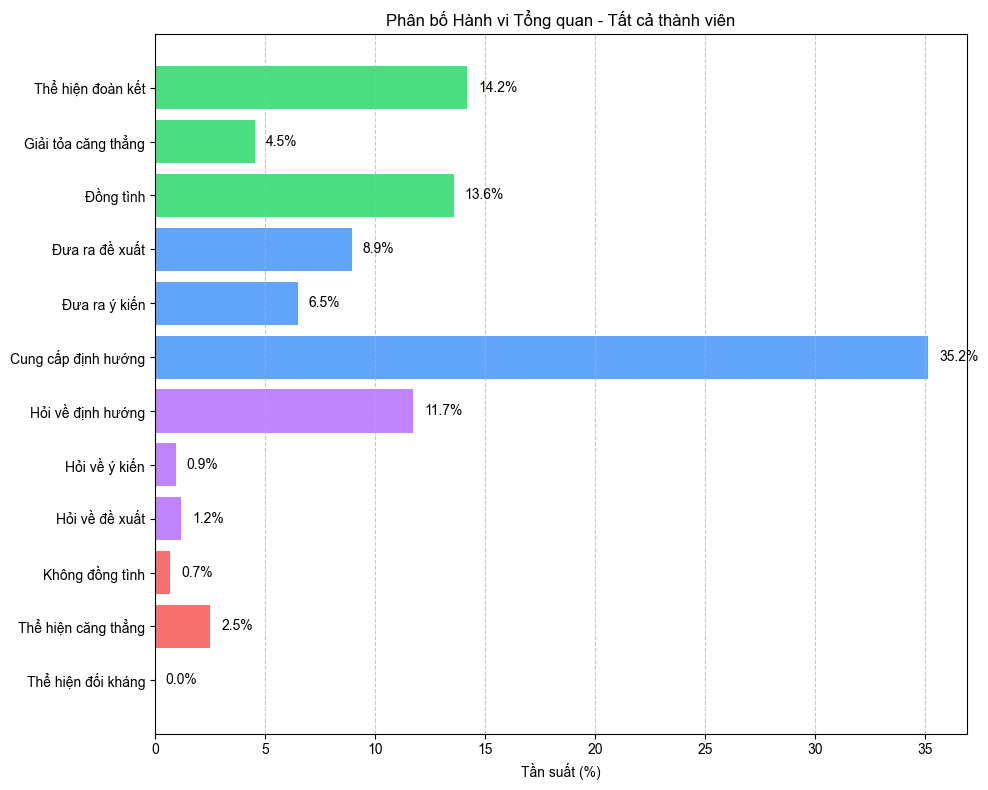

C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


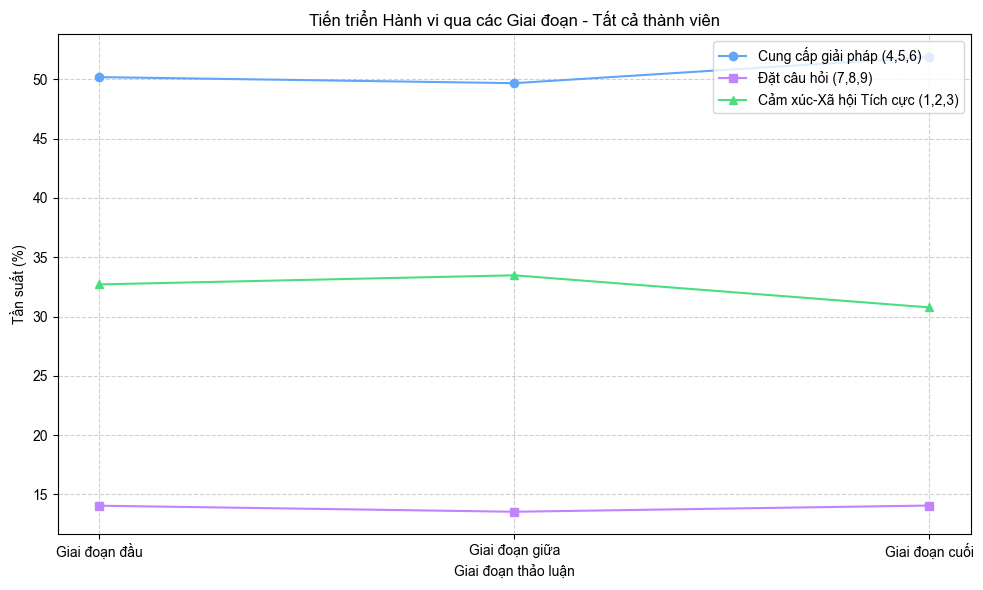

KẾT THÚC PHÂN TÍCH CHO: TẤT CẢ THÀNH VIÊN

--------------------------------------------------
BẮT ĐẦU PHÂN TÍCH CHO: TOM
--------------------------------------------------

--- CÁC TỶ LỆ CHÍNH ---
Tỷ lệ Tích cực / Tiêu cực: 2.74
Tỷ lệ Nhiệm vụ / Cảm xúc-Xã hội: 1.28
Tỷ lệ Câu hỏi / Trả lời: 1.12



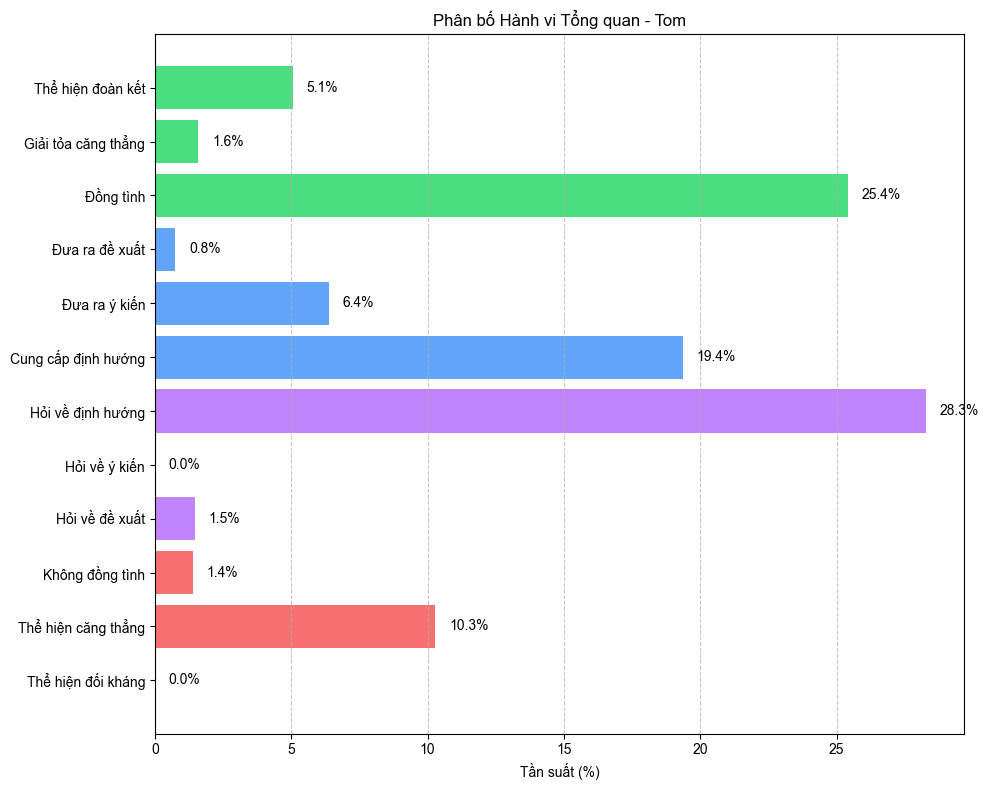

C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


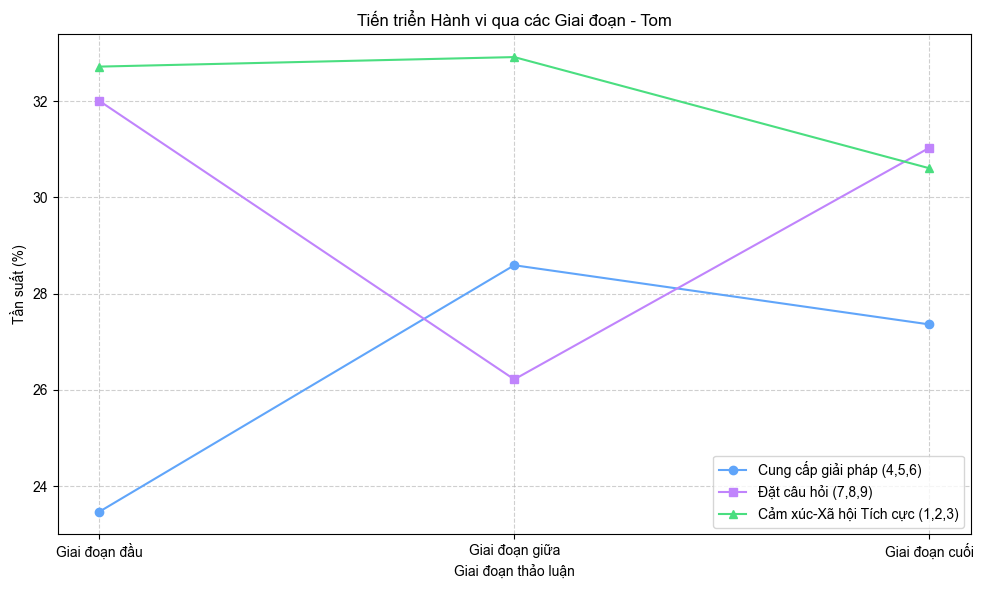

KẾT THÚC PHÂN TÍCH CHO: TOM

--------------------------------------------------
BẮT ĐẦU PHÂN TÍCH CHO: BOB
--------------------------------------------------

--- CÁC TỶ LỆ CHÍNH ---
Tỷ lệ Tích cực / Tiêu cực: 684.00
Tỷ lệ Nhiệm vụ / Cảm xúc-Xã hội: 2.51
Tỷ lệ Câu hỏi / Trả lời: 0.36



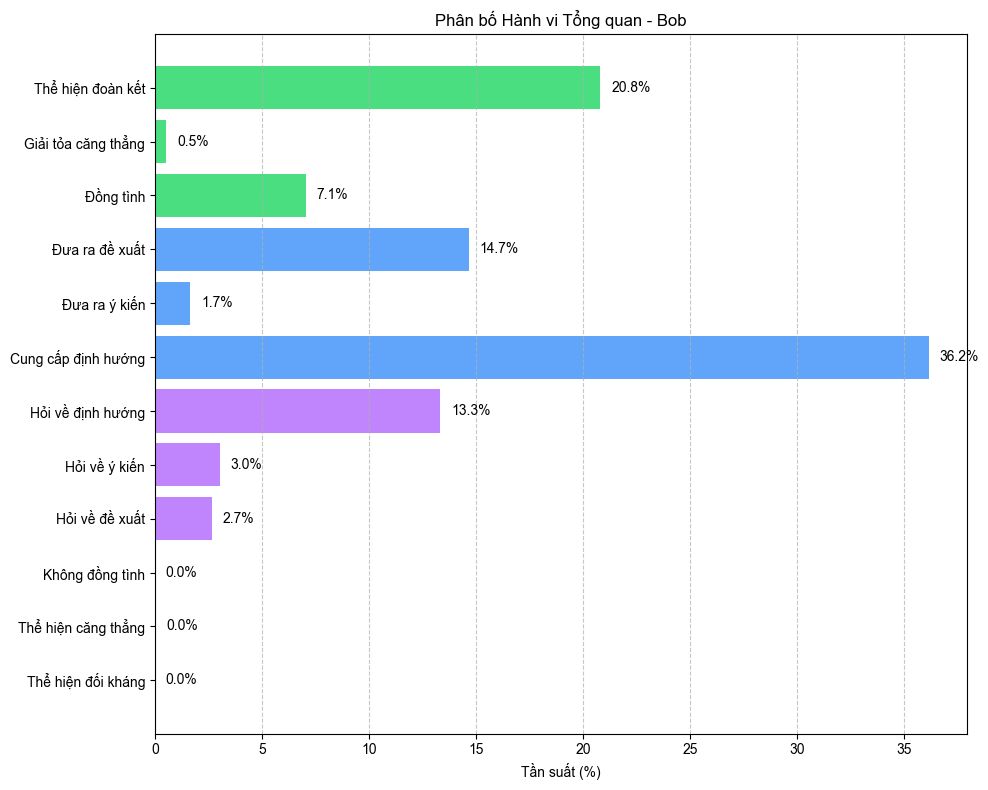

C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


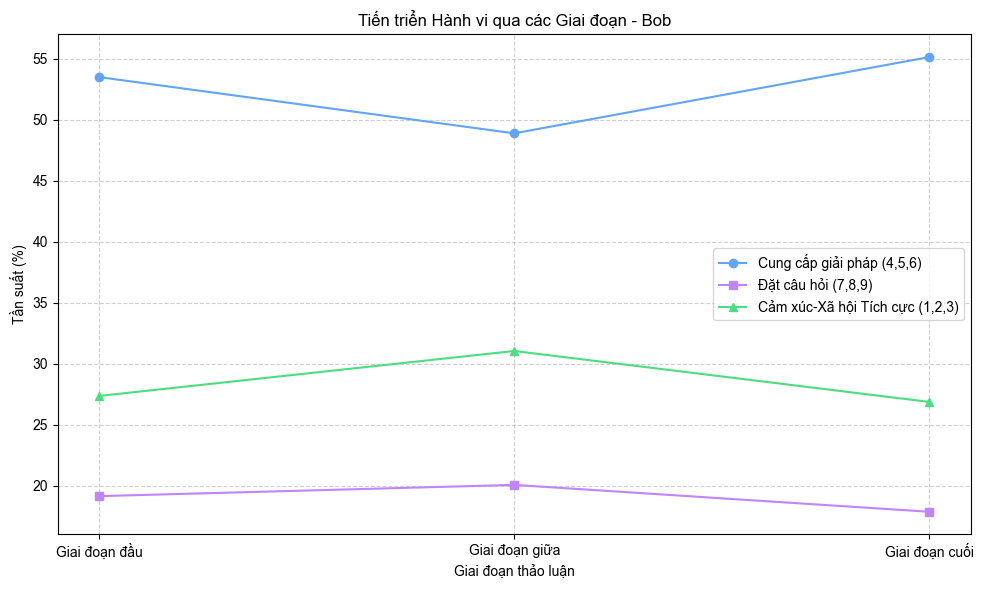

KẾT THÚC PHÂN TÍCH CHO: BOB

--------------------------------------------------
BẮT ĐẦU PHÂN TÍCH CHO: ALICE
--------------------------------------------------

--- CÁC TỶ LỆ CHÍNH ---
Tỷ lệ Tích cực / Tiêu cực: 30.29
Tỷ lệ Nhiệm vụ / Cảm xúc-Xã hội: 3.26
Tỷ lệ Câu hỏi / Trả lời: 0.08



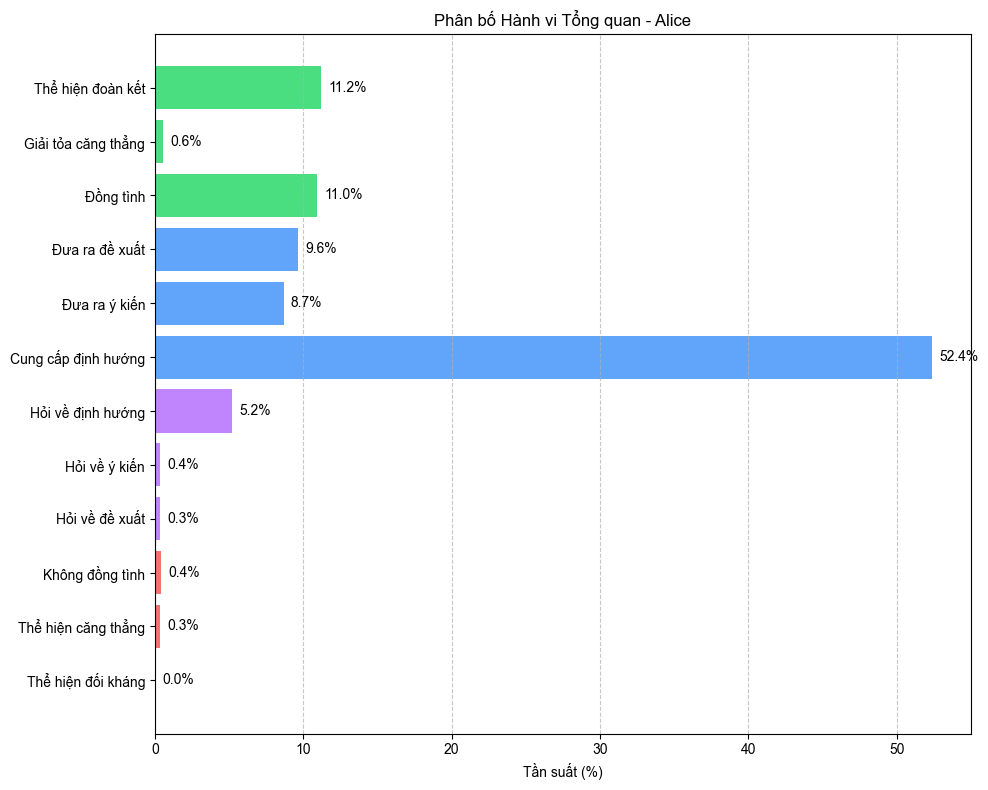

C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


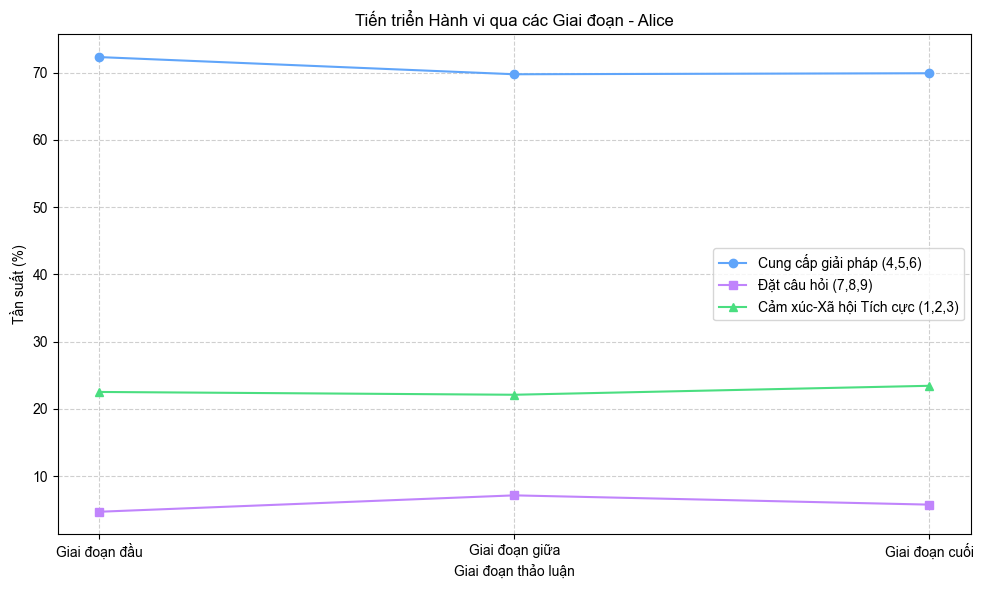

KẾT THÚC PHÂN TÍCH CHO: ALICE

--------------------------------------------------
BẮT ĐẦU PHÂN TÍCH CHO: CHARLIE
--------------------------------------------------

--- CÁC TỶ LỆ CHÍNH ---
Tỷ lệ Tích cực / Tiêu cực: 28.18
Tỷ lệ Nhiệm vụ / Cảm xúc-Xã hội: 1.01
Tỷ lệ Câu hỏi / Trả lời: 0.08



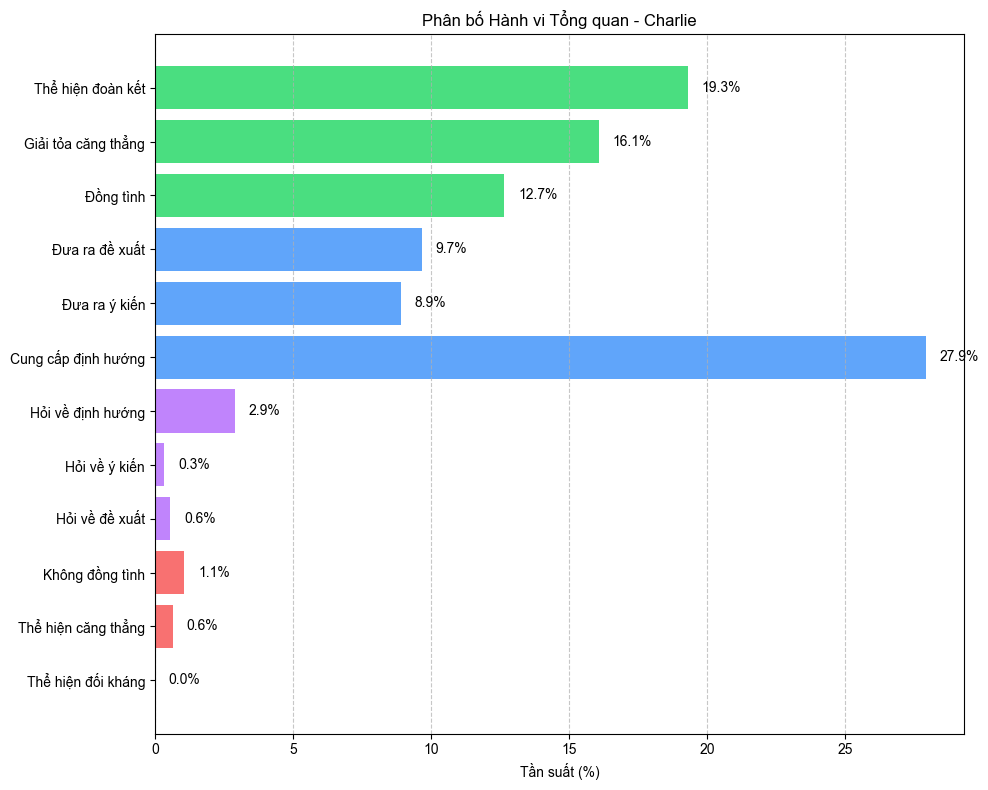

C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


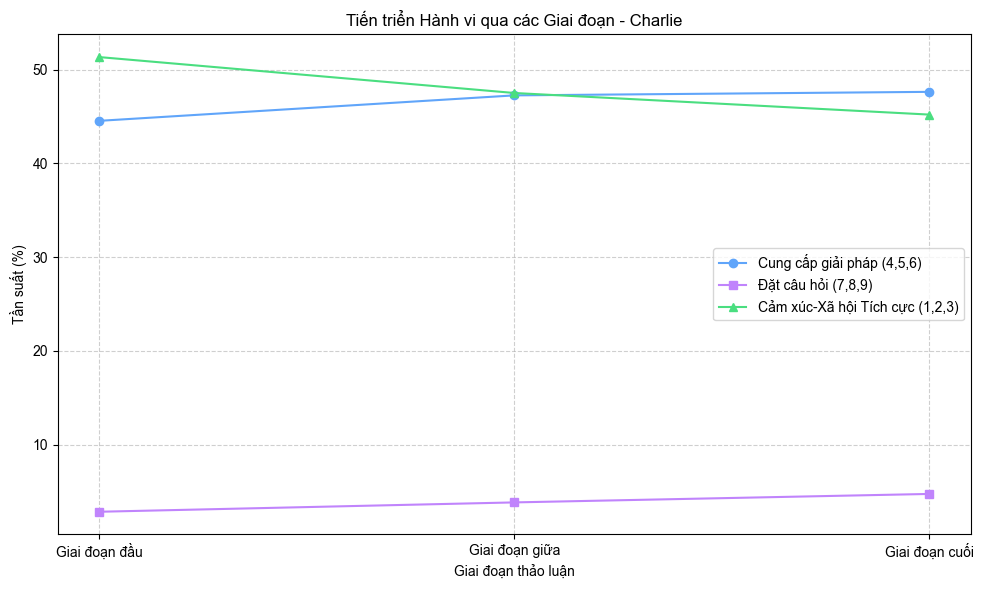

KẾT THÚC PHÂN TÍCH CHO: CHARLIE



In [11]:
# Thiết lập font hỗ trợ tiếng Việt
plt.rcParams['font.sans-serif'] = ['Inter', 'Arial', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False

# Tải dữ liệu
full_dataset = load_data_from_file(all_his)

if not full_dataset.empty:
    # Lấy danh sách các thành viên
    agents = full_dataset['sender'].unique().tolist()
    
    # Chạy phân tích cho cả nhóm
    run_analysis_for_agent(full_dataset, 'Tất cả thành viên')

    # Chạy phân tích cho một thành viên cụ thể (ví dụ: Phạm Gia Huy)
    for agent in agents:
        run_analysis_for_agent(full_dataset, agent)

In [26]:
import matplotlib.pyplot as plt
from collections import defaultdict

def bale_plot(Huy_res):
    category_names = [
        "Shows Solidarity", "Shows Tension Release", "Agrees", "Gives Suggestion",
        "Gives Opinion", "Gives Orientation", "Asks for Orientation", "Asks for Opinion",
        "Asks for Suggestion", "Disagrees", "Shows Tension", "Shows Antagonism", "None of the Above"
    ]

    # Lấy danh sách senders
    senders = sorted({entry.get("SENDER", "Unknown") for entry in Huy_res})

    # Khởi tạo dict đếm
    counts = {sender: {name: 0 for name in category_names} for sender in senders}

    # Đếm category, bỏ qua các mục không có trường 'name' hoặc name không nằm trong category_names
    for entry in Huy_res:
        sender = entry.get("SENDER", "Unknown")
        for cat in entry.get("CATEGORY", []):
            name = cat.get("name")
            if name in counts[sender]:
                counts[sender][name] += 1
            else:
                # gom vào "None of the Above" nếu không tìm thấy tên category
                counts[sender]["None of the Above"] += 1

    # Lấy 13 màu khác nhau từ colormap
    cmap = plt.get_cmap('tab20')
    colors = [cmap(i) for i in range(len(category_names))]

    # Tạo đủ số subplot dựa trên số senders (tối đa 2 cột)
    n = len(senders)
    ncols = 2
    nrows = (n + 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 5 * nrows))
    axes = axes.flatten()

    for ax, sender in zip(axes, senders):
        values = [counts[sender][name] for name in category_names]
        ax.bar(category_names, values, color=colors)
        ax.set_title(sender)
        ax.set_xlabel("Category")
        ax.set_ylabel("Count")
        ax.set_xticks(range(len(category_names)))
        ax.set_xticklabels(category_names, rotation=45, ha='right')

    # Ẩn các axes thừa (nếu có)
    for ax in axes[n:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()


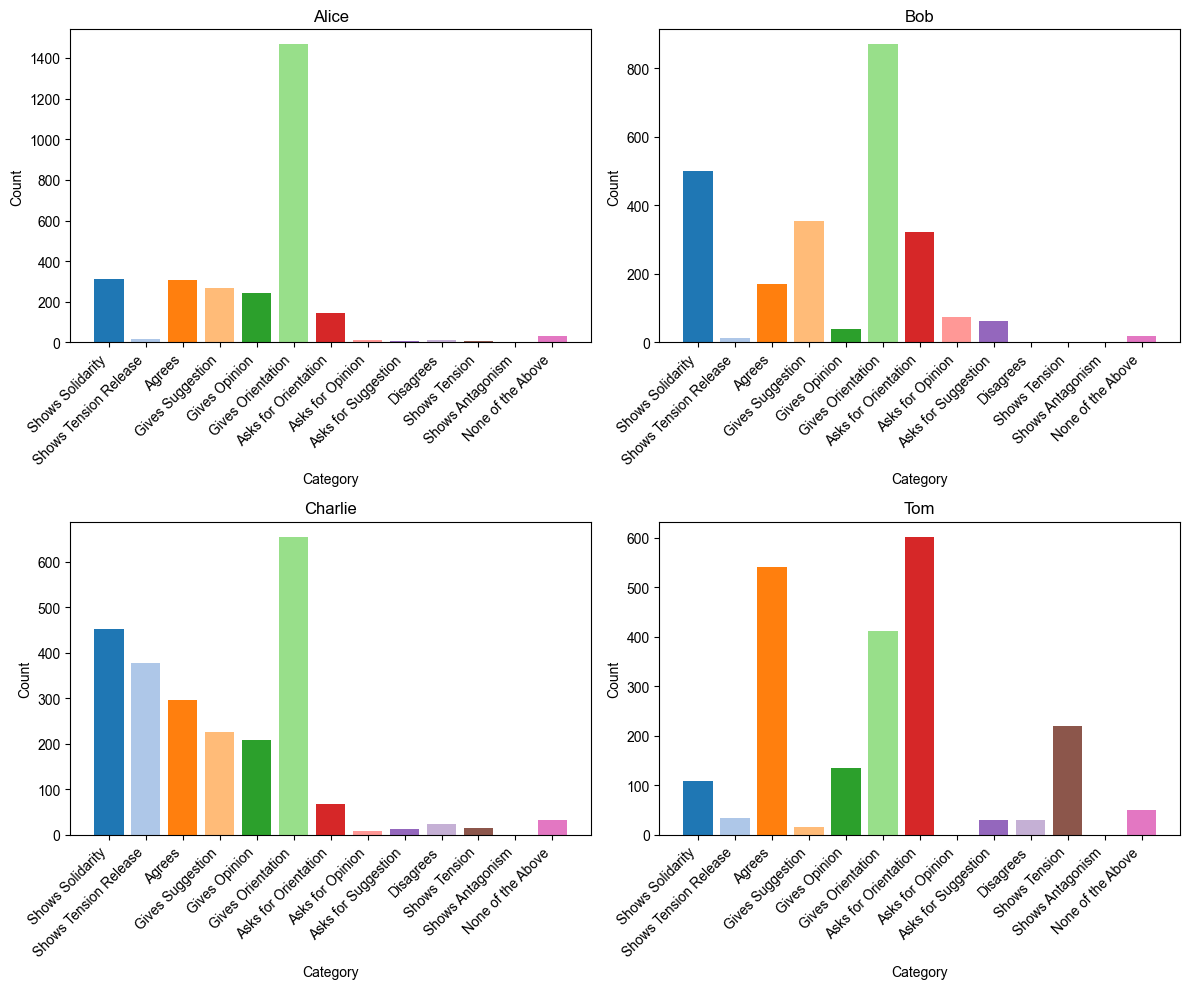

In [27]:
bale_plot(all_his)

In [29]:
# WordCloud

Alice = []
Bob = []
Charlie = []
Alice_r = []
Bob_r = []
Charlie_r = []

In [31]:
all_his[0]

{'CON': '1',
 'SENDER': 'Tom',
 'REASON': 'Tom đưa ra một bài toán mới để cả nhóm cùng giải quyết. Đây là hành động cung cấp thông tin và định hướng cho buổi học.',
 'CATEGORY': [{'cat': '6',
   'name': 'Gives Orientation',
   'key': ['đưa ra', 'cung cấp bài']}]}

In [32]:
from collections import defaultdict

# Khởi tạo dict để chứa lý do (reasons) và các key cho mỗi sender
reasons = defaultdict(list)
keys = defaultdict(list)

for entry in all_his:
    sender = entry.get('SENDER')
    if not sender:
        continue
    
    # Thêm REASON vào danh sách của người gửi
    reasons[sender].append(entry.get('REASON', ''))
    
    # Duyệt qua các CATEGORY, gom tất cả các key
    for cat in entry.get('CATEGORY', []):
        for k in cat.get('key', []):
            keys[sender].append(k)

# Giờ bạn có dict reasons và keys, ví dụ:
Bob_r      = reasons['Bob']
Alice_r    = reasons['Alice']
Charlie_r  = reasons['Charlie']

Bob_keys   = keys['Bob']
Alice_keys = keys['Alice']
Charlie_keys = keys['Charlie']

In [33]:
len(Bob_keys)

4556

In [ ]:
Bob_keys

In [35]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

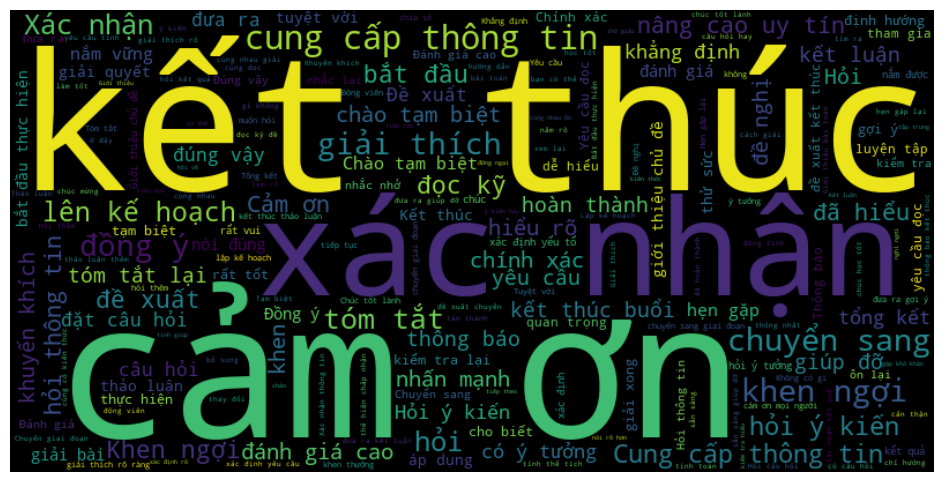

In [40]:
# Tính tần suất
freq = Counter(Bob_keys)

# Tạo word cloud từ tần suất
wc = WordCloud(width=800, height=400)
wc.generate_from_frequencies(freq)

# Vẽ word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

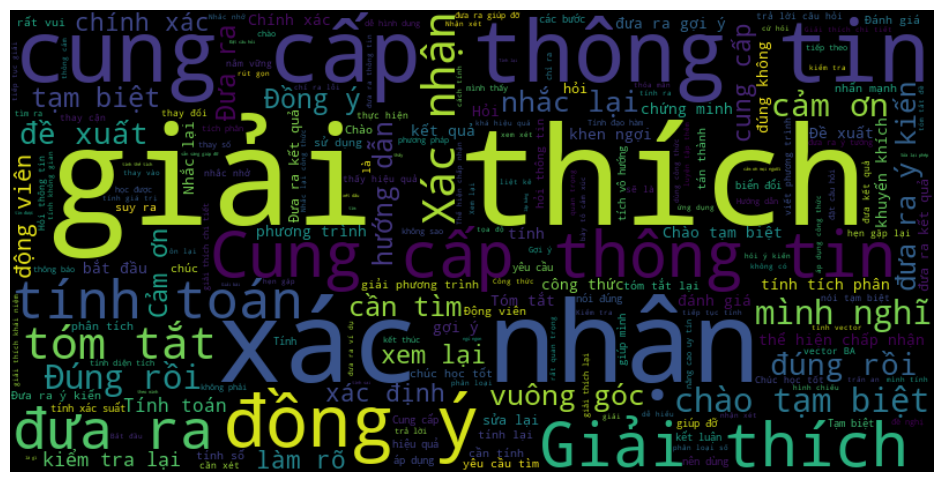

In [39]:
freq = Counter(Alice_keys)

# Tạo word cloud từ tần suất
wc = WordCloud(width=800, height=400)
wc.generate_from_frequencies(freq)

# Vẽ word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

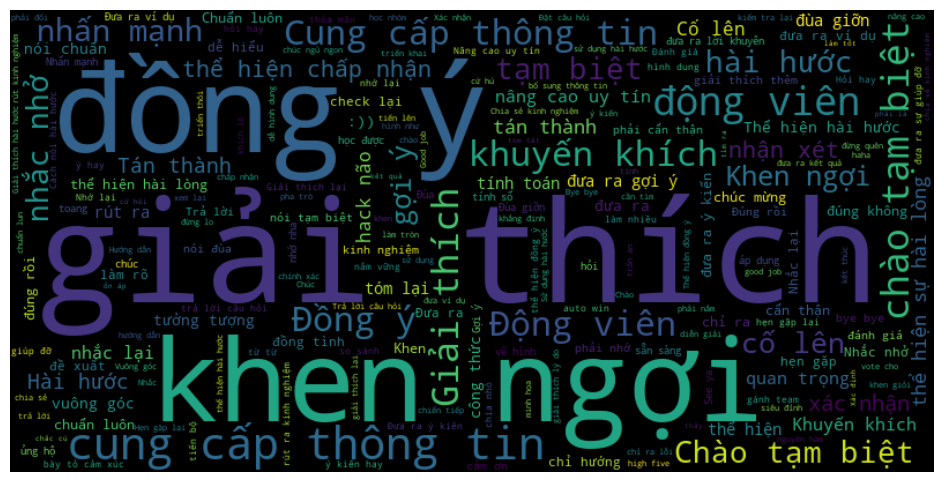

In [41]:
freq = Counter(Charlie_keys)

# Tạo word cloud từ tần suất
wc = WordCloud(width=800, height=400)
wc.generate_from_frequencies(freq)

# Vẽ word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

--- ALL MEMBERS ---
Pos/Neg: 10.06, Task/Socio: 1.81, Q/A: 0.27
--- Alice --- Pos/Neg: 30.29, Task/Socio: 3.26, Q/A: 0.08
--- Bob --- Pos/Neg: 684.00, Task/Socio: 2.51, Q/A: 0.36
--- Charlie --- Pos/Neg: 28.18, Task/Socio: 1.01, Q/A: 0.08
--- Tom --- Pos/Neg: 2.74, Task/Socio: 1.28, Q/A: 1.12


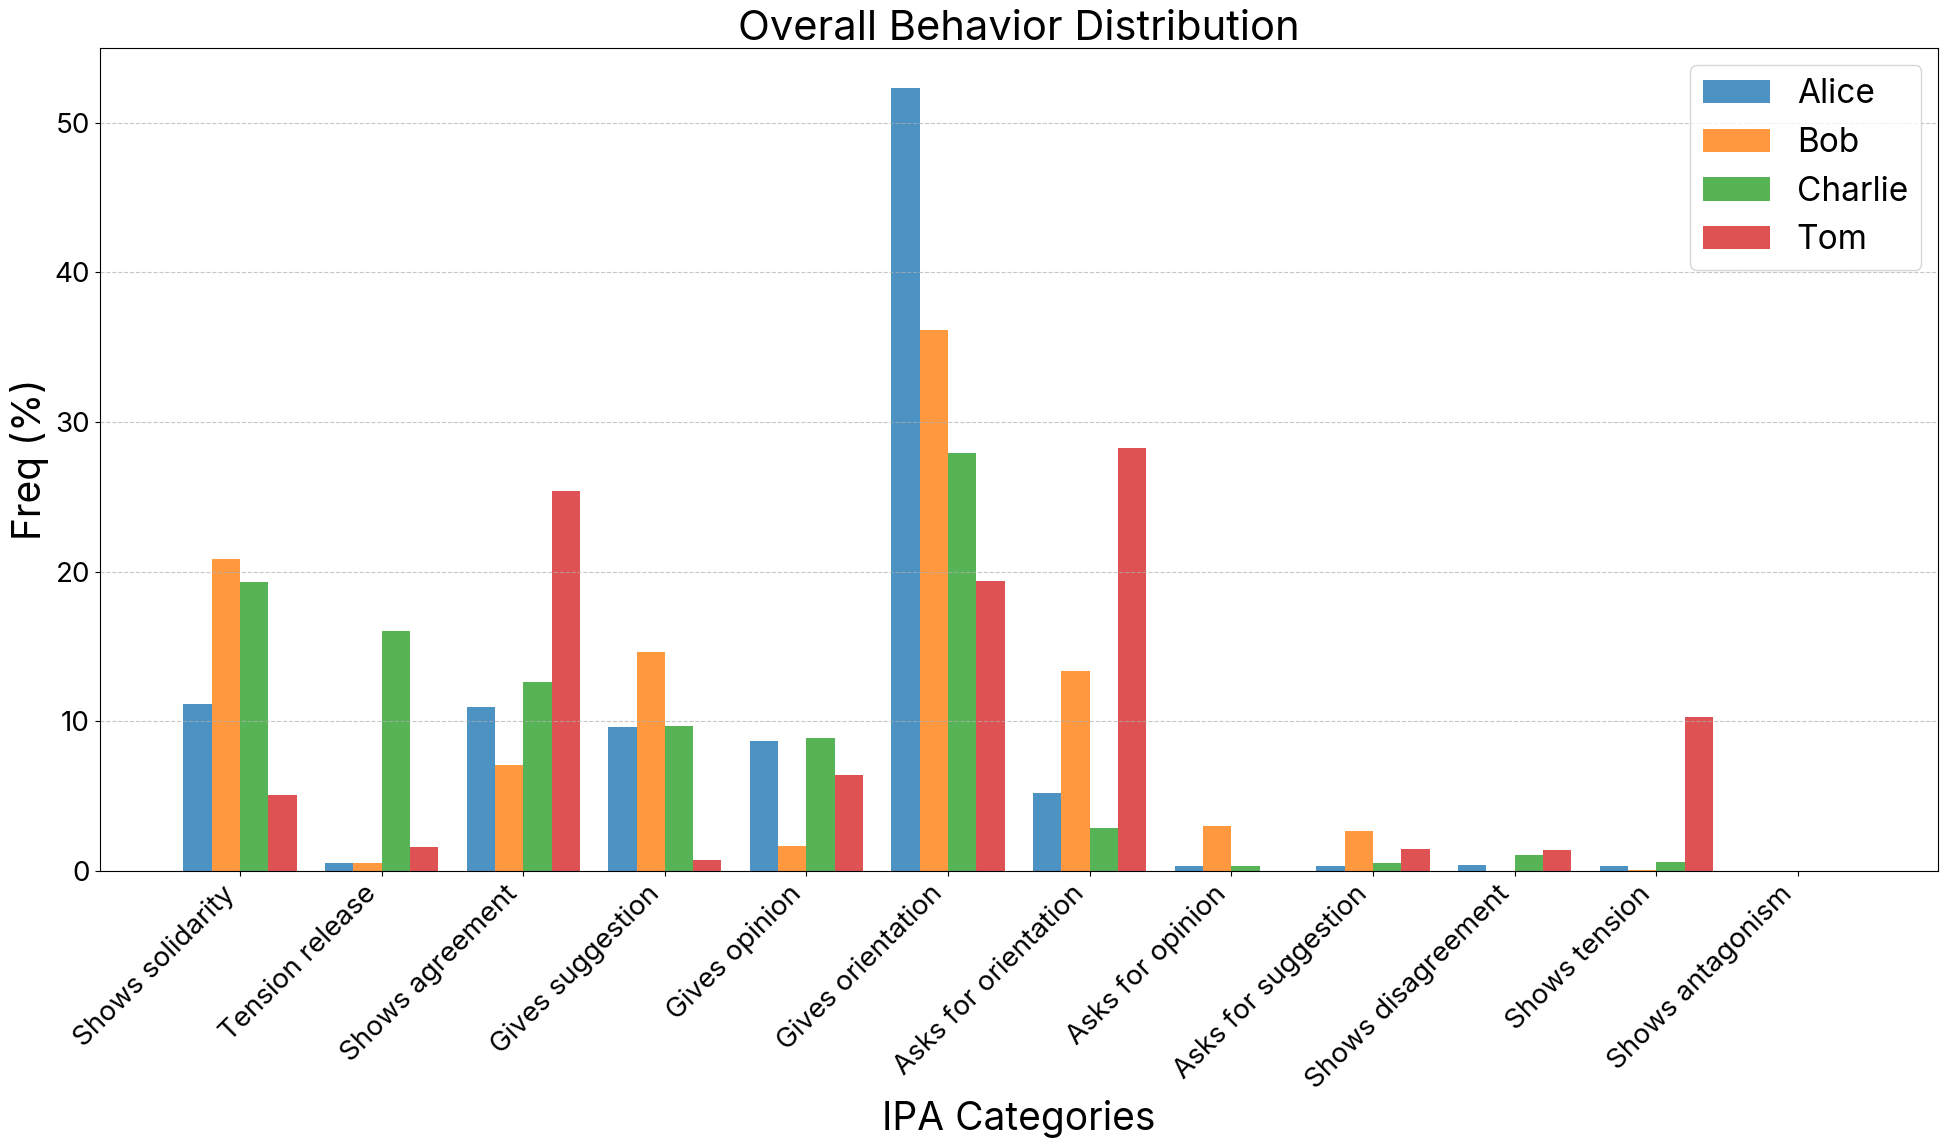

/home/huy/anaconda3/envs/aitutor/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/huy/anaconda3/envs/aitutor/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/huy/anaconda3/envs/aitutor/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/huy/anaconda3/envs/aitutor/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  retu

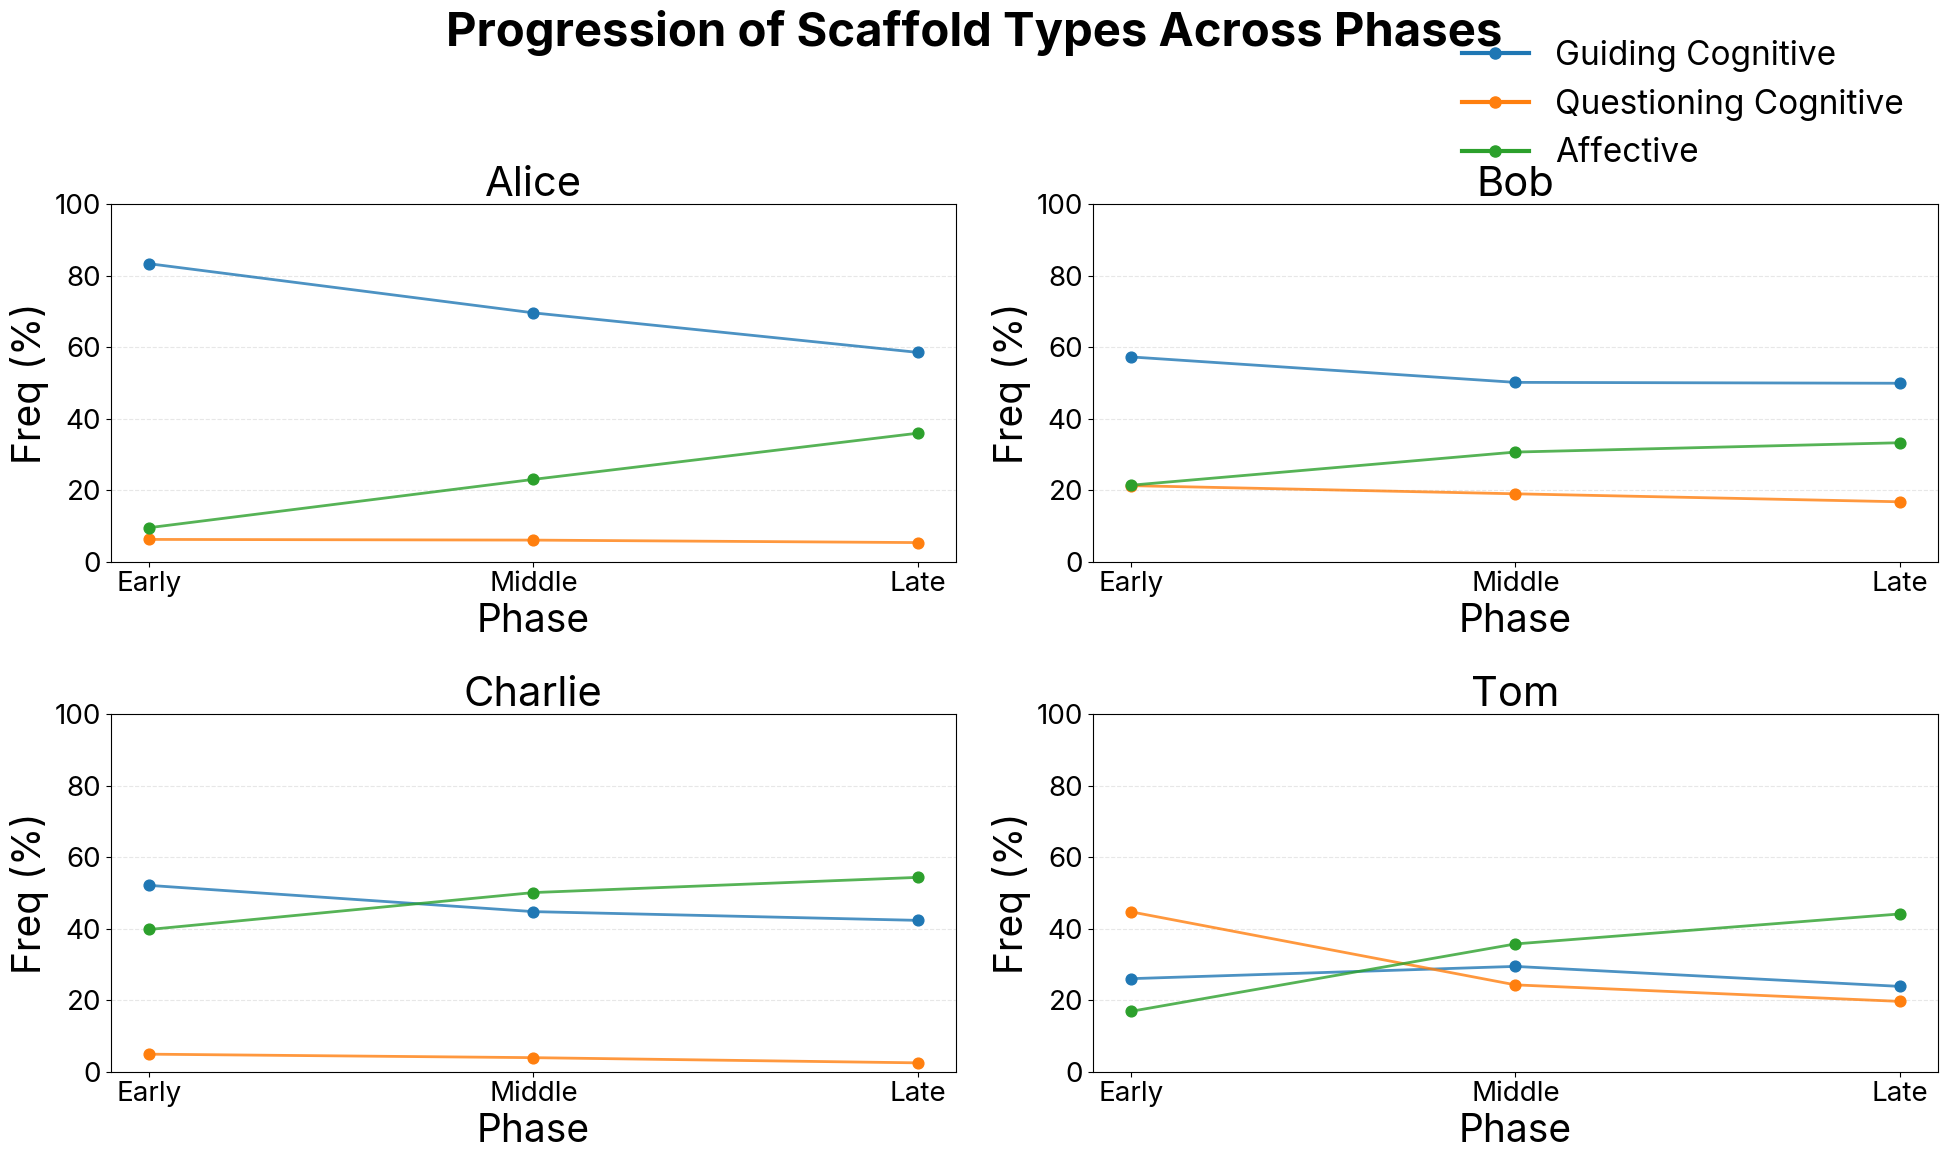

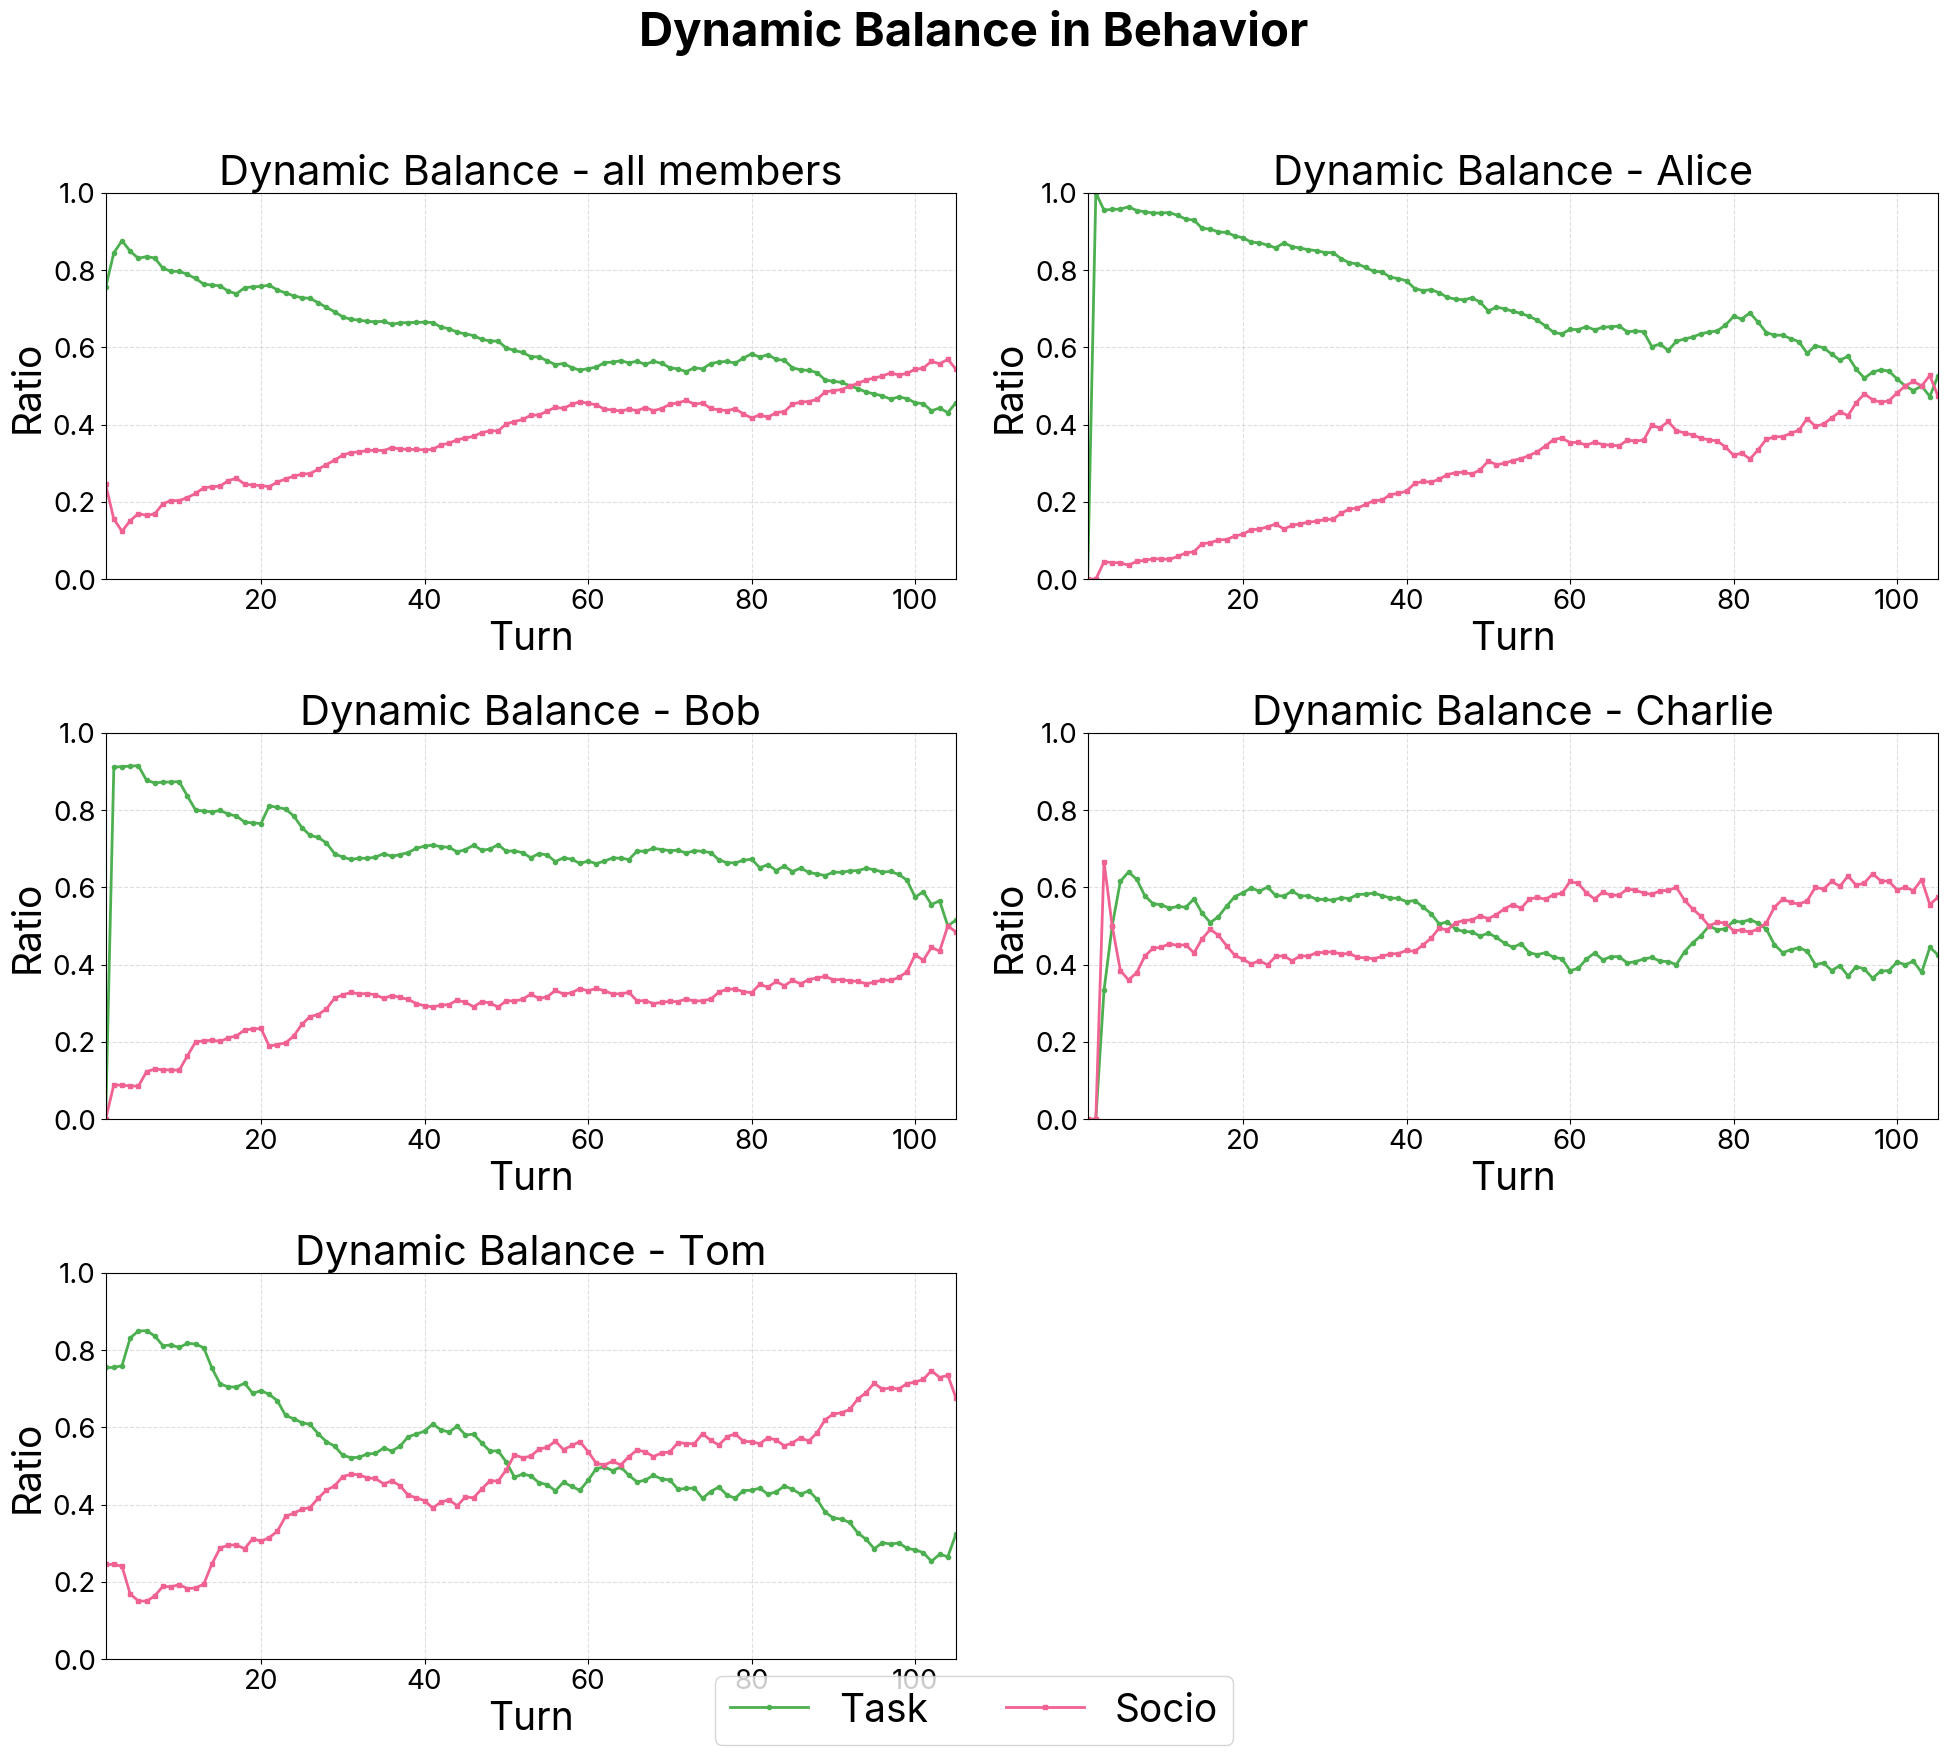

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

# --- Data and Configuration ---
IPA_CATEGORIES = {
    '1': {'name': 'Shows solidarity', 'group': 'A', 'color': '#4ade80'},
    '2': {'name': 'Tension release', 'group': 'A', 'color': '#4ade80'},
    '3': {'name': 'Shows agreement', 'group': 'A', 'color': '#4ade80'},
    '4': {'name': 'Gives suggestion', 'group': 'B', 'color': '#60a5fa'},
    '5': {'name': 'Gives opinion', 'group': 'B', 'color': '#60a5fa'},
    '6': {'name': 'Gives orientation', 'group': 'B', 'color': '#60a5fa'},
    '7': {'name': 'Asks for orientation', 'group': 'C', 'color': '#c084fc'},
    '8': {'name': 'Asks for opinion', 'group': 'C', 'color': '#c084fc'},
    '9': {'name': 'Asks for suggestion', 'group': 'C', 'color': '#c084fc'},
    '10': {'name': 'Shows disagreement', 'group': 'D', 'color': '#f87171'},
    '11': {'name': 'Shows tension', 'group': 'D', 'color': '#f87171'},
    '12': {'name': 'Shows antagonism', 'group': 'D', 'color': '#f87171'},
    '13': {'name': 'Unclassified', 'group': 'E', 'color': '#9ca3af'}
}

POSITIVE_CATS = ['1', '2', '3']
NEGATIVE_CATS = ['10', '11', '12']
TASK_ANSWER_CATS = ['4', '5', '6']
TASK_QUESTION_CATS = ['7', '8', '9']
SOCIOEMOTIONAL_CATS = POSITIVE_CATS + NEGATIVE_CATS
TASK_CATS = TASK_ANSWER_CATS + TASK_QUESTION_CATS

def load_data_from_file(filename='his_97_bale.json'):
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except Exception as e:
        print(f"Error loading '{filename}': {e}")
        return pd.DataFrame()

    rows = []
    for session in data:
        for entry in session.get('bale', []):
            for cat in entry.get('CATEGORY', []):
                rows.append({
                    'turn': int(entry.get('CON', 0)),
                    'sender': entry.get('SENDER', 'Unknown'),
                    'category_id': cat.get('cat'),
                    'category_name': IPA_CATEGORIES.get(cat.get('cat'), {}).get('name', 'Unknown')
                })
    if not rows:
        return pd.DataFrame()
    df = pd.DataFrame(rows).sort_values('turn').reset_index(drop=True)
    return df

def calculate_statistics(df):
    if df.empty:
        return pd.Series(), pd.Series(), {}
    counts = df['category_id'].value_counts().reindex(IPA_CATEGORIES.keys(), fill_value=0)
    total = counts.drop('13', errors='ignore').sum()
    percentages = counts / total * 100 if total > 0 else counts
    pos, neg = counts.loc[POSITIVE_CATS].sum(), counts.loc[NEGATIVE_CATS].sum()
    task, socio = counts.loc[TASK_CATS].sum(), counts.loc[SOCIOEMOTIONAL_CATS].sum()
    ques, ans = counts.loc[TASK_QUESTION_CATS].sum(), counts.loc[TASK_ANSWER_CATS].sum()
    return counts, percentages, {
        'positivity': pos/neg if neg>0 else float('inf') if pos>0 else 0,
        'task_socio': task/socio if socio>0 else float('inf') if task>0 else 0,
        'ques_ans': ques/ans if ans>0 else float('inf') if ques>0 else 0
    }

def plot_all_distribution_charts(full_df, agents):
    cats = {k:v for k,v in IPA_CATEGORIES.items() if k!='13'}
    labels = [v['name'] for v in cats.values()]
    colors = [v['color'] for v in cats.values()]
    
    # Prepare data for all members and agents
    plot_names = agents
    data_matrix = []
    
    for name in plot_names:
        sub = full_df if name=='all members' else full_df[full_df['sender']==name]
        if sub.empty:
            data_matrix.append([0] * len(cats))
        else:
            _, pct, _ = calculate_statistics(sub)
            data_matrix.append([pct[k] for k in cats.keys()])
    
    # Create grouped bar chart
    fig, ax = plt.subplots(figsize=(20, 12))
    
    x = np.arange(len(labels))
    width = 0.8 / len(plot_names)
    
    for i, (name, data) in enumerate(zip(plot_names, data_matrix)):
        offset = (i - len(plot_names)/2) * width + width/2
        ax.bar(x + offset, data, width, label=name, alpha=0.8)
    
    ax.set_xlabel('IPA Categories')
    ax.set_ylabel('Freq (%)')
    ax.set_title('Overall Behavior Distribution')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig("figs/distribution_chart.png", dpi=300, bbox_inches='tight')
    plt.show()
    
def plot_all_timeseries_charts(full_df, agents):
    plot_list = agents
    n = len(plot_list)
    cols = 2; rows = math.ceil(n/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(20, 6*rows))
    axes = axes.flatten()

    common_handles, common_labels = None, None
    for i, name in enumerate(plot_list):
        ax = axes[i]
        sub = full_df if name=='all members' else full_df[full_df['sender']==name]
        if len(sub)<3:
            ax.text(0.5,0.5,f'Not enough data for {name}',ha='center'); ax.axis('off'); continue
        parts = np.array_split(sub,3)
        phases = ['Early','Middle','Late']
        ans, ques, pos = [],[],[]
        for part in parts:
            c,_,_ = calculate_statistics(part)
            tot=c.drop('13',errors='ignore').sum()
            ans.append(c.loc[TASK_ANSWER_CATS].sum()/tot*100 if tot>0 else 0)
            ques.append(c.loc[TASK_QUESTION_CATS].sum()/tot*100 if tot>0 else 0)
            pos.append(c.loc[POSITIVE_CATS].sum()/tot*100 if tot>0 else 0)

        # Slopegraph implementation
        x_positions = [0, 1, 2]
        metrics = [('Guiding Cognitive', ans, '#1f77b4'), ('Questioning Cognitive', ques, '#ff7f0e'), ('Affective', pos, '#2ca02c')]
        
        for metric_name, values, color in metrics:
            # Plot lines
            ax.plot(x_positions, values, color=color, linewidth=2, alpha=0.8)
            # Plot points
            ax.scatter(x_positions, values, color=color, s=60, zorder=5)
        
        if i==0:
            common_handles = [plt.Line2D([0], [0], color=color, linewidth=3, marker='o', markersize=8) for _, _, color in metrics]
            common_labels = [name for name, _, _ in metrics]
        
        # Remove local legend safely
        legend = ax.get_legend()
        if legend: legend.remove()
        
        ax.set_title(f'{name}')
        ax.set_xlabel('Phase')
        ax.set_ylabel('Freq (%)')
        ax.set_xticks(x_positions)
        ax.set_xticklabels(phases)
        ax.grid(True, linestyle='--', alpha=0.3, axis='y')
        ax.set_ylim(0, 100)

    for j in range(n, len(axes)):
        axes[j].axis('off')
    plt.tight_layout(rect=[0,0,1,0.88])
    fig.suptitle('Progression of Scaffold Types Across Phases', fontsize=34, weight='bold')
    fig.legend(common_handles, common_labels, loc='upper right', bbox_to_anchor=(0.98, 0.98), fontsize=24, frameon=False)
    plt.savefig("figs/timeseries_chart.png", dpi=300, bbox_inches='tight')
    plt.show()

def plot_all_dynamic_balance_charts(full_df, agents, window_size=5):
    plot_list = ['all members'] + agents
    n = len(plot_list)
    cols = 2; rows = math.ceil(n/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(20, 6*rows))
    axes = axes.flatten()

    common_handles, common_labels = None, None
    max_turn = int(full_df['turn'].max())

    for i, name in enumerate(plot_list):
        ax = axes[i]
        sub = full_df if name=='all members' else full_df[full_df['sender']==name]
        if sub.empty:
            ax.text(0.5,0.5,f'No data for {name}',ha='center'); ax.axis('off'); continue

        sub = sub.copy()
        sub['ipa_type'] = np.where(sub['category_id'].isin(TASK_CATS),'task','socio')
        tc = sub.groupby('turn')['ipa_type'].value_counts().unstack(fill_value=0)
        tc = tc.reindex(range(1, max_turn+1), fill_value=0)

        win = tc['task'].rolling(window_size, min_periods=1).sum()
        wio = tc['socio'].rolling(window_size, min_periods=1).sum()
        total = win + wio
        tr = (win/total).fillna(0); sr = (wio/total).fillna(0)

        h1, = ax.plot(range(1, max_turn+1), tr, 
                      label='Task', linewidth=2, color='#4caf50', marker='o', markersize=3)
        h2, = ax.plot(range(1, max_turn+1), sr, 
                      label='Socio', linewidth=2, color='#f06292', marker='s', markersize=3)
        if i==0:
            common_handles, common_labels = [h1, h2], ['Task', 'Socio']
        legend = ax.get_legend()
        if legend: legend.remove()
        ax.set_title(f'Dynamic Balance - {name}')
        ax.set_xlabel('Turn'); ax.set_ylabel('Ratio')
        ax.set_ylim(0,1); ax.set_xlim(1,max_turn)
        ax.grid(True, linestyle='--', alpha=0.4)

    for j in range(n, len(axes)):
        axes[j].axis('off')
    plt.tight_layout(rect=[0,0,1,0.92])
    fig.suptitle('Dynamic Balance in Behavior', fontsize=34, weight='bold')
    fig.legend(common_handles, common_labels, loc='lower center', ncol=2, fontsize=28)
    plt.savefig("figs/dynamic_balance_chart.png", dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    plt.rcParams['font.sans-serif'] = ['Inter','Arial','sans-serif']
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams.update({
        'font.size': 24,
        'axes.titlesize': 30,
        'axes.labelsize': 28,
        'xtick.labelsize': 20,
        'ytick.labelsize': 20,
        'legend.fontsize': 24,
        'figure.titlesize': 34
    })

    df = load_data_from_file('his_97_bale.json')
    if df.empty:
        print("No data loaded.")
    else:
        agents = sorted(df['sender'].unique())
        # Print key ratios
        print("--- ALL MEMBERS ---")
        _,_,r = calculate_statistics(df)
        print(f"Pos/Neg: {r['positivity']:.2f}, Task/Socio: {r['task_socio']:.2f}, Q/A: {r['ques_ans']:.2f}")
        for ag in agents:
            _,_,r = calculate_statistics(df[df['sender']==ag])
            print(f"--- {ag} --- Pos/Neg: {r['positivity']:.2f}, Task/Socio: {r['task_socio']:.2f}, Q/A: {r['ques_ans']:.2f}")

        plot_all_distribution_charts(df, agents)
        plot_all_timeseries_charts(df, agents)
        plot_all_dynamic_balance_charts(df, agents, window_size=10)
